In [198]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

## Data Preprocessing

* Regex cheatsheet
    * https://www.rexegg.com/regex-quickstart.html
* Regex test - live
    * https://regexr.com/
* Datetime format
    * http://strftime.org/

In [288]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

### Import data

In [289]:
df = rawToDf('WhatsApp Chat with Bhakchodi.txt', '12hr')

In [290]:
df.tail()

date_time    user  \
6073 2019-12-21 18:42:00   Shrey   
6074 2019-12-21 19:02:00    Neha   
6075 2019-12-21 20:48:00   Shrey   
6076 2019-12-21 20:58:00  Shuchi   
6077 2019-12-21 21:02:00    Neha   

                                                    msg  
6073               Boo boo kya bhakchodi hai ye 🤷‍♂🤷‍♂   
6074  Hahaha ka ka ka ka chi chi chi🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...  
6075                                       😆😆🤦‍♂🤦‍♂🤦‍♂   
6076                              Hahahhaahahaaahah🤣🤣🤣   
6077                                                🤣🤣

In [291]:
df.shape # no. of msgs

(6078, 3)

In [292]:
me = "Shuchi"

### Data Cleaning

In [293]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

(305, 3)

In [294]:
df["user"].unique()

array(['grp_notif', 'Neha', 'Akshay', 'Nita', 'Ankush Gattewar', 'Shuchi',
       'Sumit Joshi', 'Shrey', 'tiwari ji', 'Rantu Das',
       '+91 70891 31084', 'Gautam Shandilya'], dtype=object)

In [295]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(22, 3)

In [296]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [297]:
df.tail()

date_time    user  \
6073 2019-12-21 18:42:00   Shrey   
6074 2019-12-21 19:02:00    Neha   
6075 2019-12-21 20:48:00   Shrey   
6076 2019-12-21 20:58:00  Shuchi   
6077 2019-12-21 21:02:00    Neha   

                                                    msg  
6073               Boo boo kya bhakchodi hai ye 🤷‍♂🤷‍♂   
6074  Hahaha ka ka ka ka chi chi chi🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣...  
6075                                       😆😆🤦‍♂🤦‍♂🤦‍♂   
6076                              Hahahhaahahaaahah🤣🤣🤣   
6077                                                🤣🤣

In [298]:
df.reset_index(inplace=True, drop=True)
df.shape

(5751, 3)

# Lets Discuss on what do we want to get out of this data
    * Is raw data enough to get that insight?
    * if not what can be possible way to get that insight?
    * Whats the use of that insight?
    
**Questions from the audience**

## Q 1) Who is the most active member of the group. Who is the least active?

In [299]:
df.groupby("user")["msg"].count().sort_values(ascending=False)

user
Shuchi              1586
Neha                1501
Akshay               730
tiwari ji            677
Shrey                559
Nita                 312
Ankush Gattewar      191
Sumit Joshi          120
Gautam Shandilya      44
Rantu Das             29
+91 70891 31084        2
Name: msg, dtype: int64

## Q 2) Count of all the emojis that i have used?

In [300]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [301]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

🤣 - 1391
🏻 - 850
🤭 - 379
♀ - 373
😘 - 314
🤷 - 208
🖕 - 186
🤦 - 172
🤪 - 152
🙈 - 150


## Q 3) What can my activity say about my sleep cycle?

In [302]:
def to_hour(val):
    return val.hour

In [303]:
df['hour'] = df['date_time'].apply(to_hour)

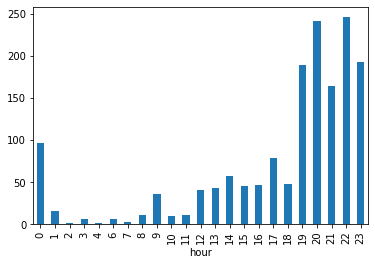

In [304]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [305]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [306]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [307]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

Shuchi              1586
Neha                1501
Akshay               730
tiwari ji            677
Shrey                559
Nita                 312
Ankush Gattewar      191
Sumit Joshi          120
Gautam Shandilya      44
Rantu Das             29
+91 70891 31084        2
Name: user, dtype: int64

In [308]:
top5_users = msgs_per_user.index.tolist()[:5]
top5_users

['Shuchi', 'Neha', 'Akshay', 'tiwari ji', 'Shrey']

In [309]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

date_time    user                      msg  hour weekday  \
0 2019-06-10 18:50:00    Neha  Ohhh yeahhh😍😍😍😍😍😍😍😍😍😍😍     18  Monday   
1 2019-06-10 18:50:00  Akshay            🤦🏼‍♂🤦🏼‍♂🤦🏼‍♂     18  Monday   
5 2019-06-10 18:51:00    Neha                      🤭🤭     18  Monday   
6 2019-06-10 18:53:00  Shuchi          Coz its mah no     18  Monday   
8 2019-06-10 18:53:00  Shuchi                 Watsap😛     18  Monday   

   is_weekend  
0       False  
1       False  
5       False  
6       False  
8       False

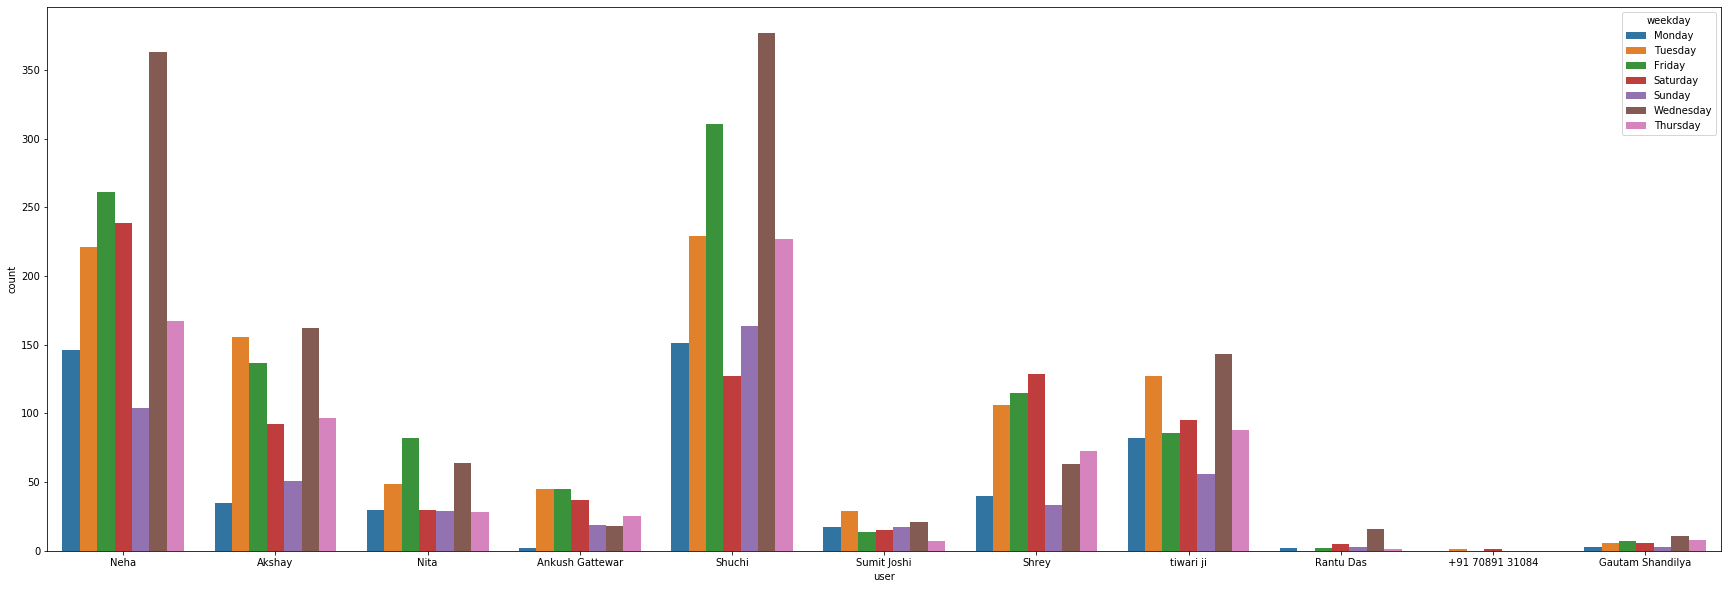

In [310]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

In [311]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

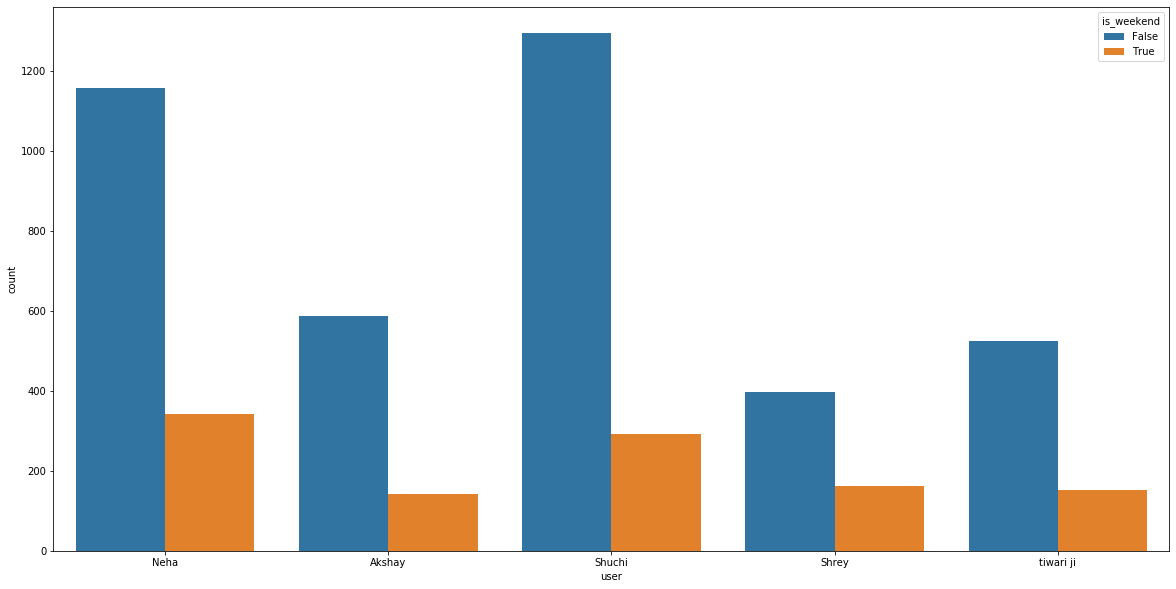

In [312]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

In [313]:
def word_count(val):
    return len(val.split())

In [314]:
df['no_of_words'] = df['msg'].apply(word_count)

In [315]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [316]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

14238

In [317]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

3942

In [318]:
total_words_weekday/5 # average words on a weekday

2847.6

In [319]:
total_words_weekend/2 # average words on a weekend

1971.0

In [320]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Shuchi              4139
tiwari ji           3521
Neha                3220
Akshay              3157
Shrey               1429
Nita                1157
Ankush Gattewar      910
Sumit Joshi          308
Gautam Shandilya     199
Rantu Das            130
+91 70891 31084       10
Name: no_of_words, dtype: int64

In [321]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
tiwari ji    5.200886
Akshay       4.324658
Shuchi       2.609710
Shrey        2.556351
Neha         2.145237
dtype: float64

In [322]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user       is_weekend
Akshay     False         4.265758
           True          4.566434
Neha       False         2.158895
           True          2.099125
Shrey      False         2.506297
           True          2.679012
Shuchi     False         2.646332
           True          2.446735
tiwari ji  False         5.285171
           True          4.907285
dtype: float64

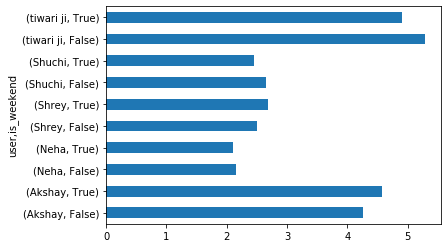

In [323]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

## Q 5)
## Most Usage - Time of Day

In [324]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
hour                                                                   
0          64.0   128.0      43.0    13.0       5.0     16.0       23.0
1           3.0     NaN       2.0    35.0       2.0      1.0        5.0
2           NaN     NaN       2.0     NaN       NaN      NaN        8.0
3           NaN     NaN       9.0     6.0       NaN      NaN        NaN
4           NaN     NaN       NaN     1.0       NaN      NaN        NaN

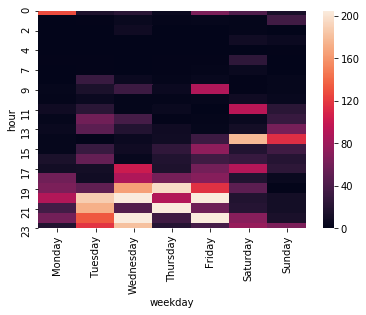

In [325]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6)
## In any group, do I have any inclination towards responding to someone? 

In [326]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[   6    8    9 ... 5728 5743 5749] (1586,)


In [327]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[   5    7    8 ... 5727 5742 5748] (1586,)


In [328]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(1586, 7)

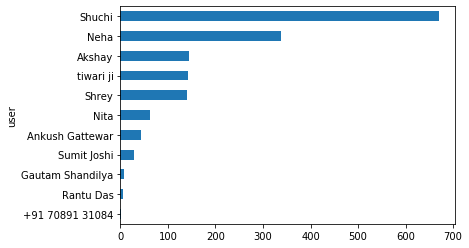

In [329]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

## Q 7)
## Which are the most common words?

In [330]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


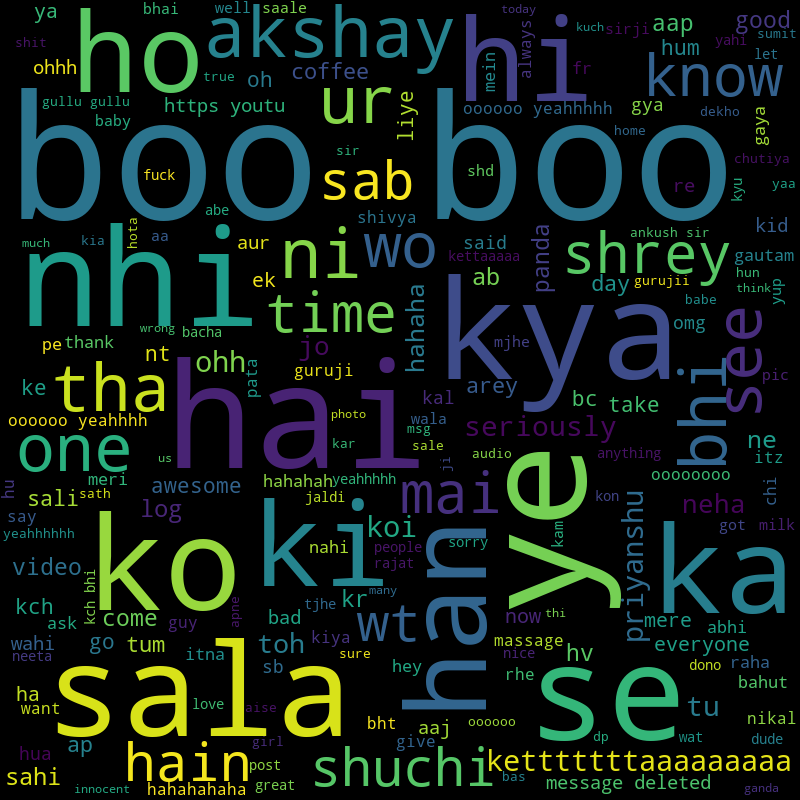

In [333]:
wordcloud.to_image()

## Know What They Know(atleast by little
* Let this meetup series encourage people to work on their own data:
    * Ask many questions on whatsapp chat data, commit to jovian with your answers/analysis visulization. Experiment!!!
* Explore more data resources here's a list i could find, share if you find any @ dsnet.org
    * WhatsApp
    * Google take out (https://takeout.google.com/)
        * Keyboard
        * Maps
        * Calendar 
        * Chrome
        * Pay
        * etc....
    * https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/
    * https://in.pcmag.com/software/120204/how-to-download-your-facebook-data-and-6-surprising-things-i-found
* Lets move step by step EDA first to try answer the questions on our own then move to some ML/DL Models 

## Assingment-kind
* 1way ya 2way, check for a response time between two people

In [ ]:
jovian.commit(notebook_id='PrajwalPrashanth/kwtk-whatsapp-refrence')

[jovian] Saving notebook..


<IPython.core.display.Javascript object>